# Advanced Function Fitting

(This notebook assumes that you have gone through the [Getting Started](https://colab.research.google.com/github/tee-lab/PyDaddy/blob/colab/notebooks/1_getting_started.ipynb) notebook. The explanations and examples in the notebook will mostly be based on vector datasets, but the ideas remains mostly unchanged for the scalar case.)

The _Getting Started_ notebook introduced how to fit functional forms for drift and diffusion terms. In those examples, the automatic model selection worked well. However, in many cases, some amount of manual intervention may be required to get the best results. 

There are two key parameters to (polynomial) function fitting; the _maximum degree_ of the polynomial, and the _sparsification threshold_. This notebook explores how to choose these parameters appropriately. 

As an experimental feature, `pydaddy` also allows us to fit functions other than polynomials, by providing a custom library. For more details on this, see [Fitting Non-polynomial Functions](https://colab.research.google.com/github/tee-lab/PyDaddy/blob/colab/notebooks/6_non_poly_function_fitting.ipynb)

In [ ]:
# Execute this cell to set up PyDaddy in your Colab environment.
%pip install git+https://github.com/tee-lab/PyDaddy.git

In [1]:
import sys
sys.path.append('/Users/nabeel/Documents/Research/Code/pyddsde')

In [2]:
import pydaddy

## Choosing the correct polynomial degree

For this notebook, we will use the group polarization time-series for a school of fish. Assuming there are no preferred directions for the school, we can expect symmetries between $F_1$ and $F_2$ and between $G_{11}$ and $G_{22}$.

The first step is to choose the right order for the polynomial. This can be done by visually inspecting the drift and diffusion plots.

| x range                           :   (-1.0, 1.0)  |
| x mean                            :      0.005     |
| y range                           :   (-1.0, 1.0)  |
| y mean                            :      0.02      |
| |(x, y)| range                    :  (0.002, 1.0)  |
| |(x, y)| mean                     :      0.778     |
| Autocorr time (x, y, |(x, y)|^2)  : (298, 264, 36) |



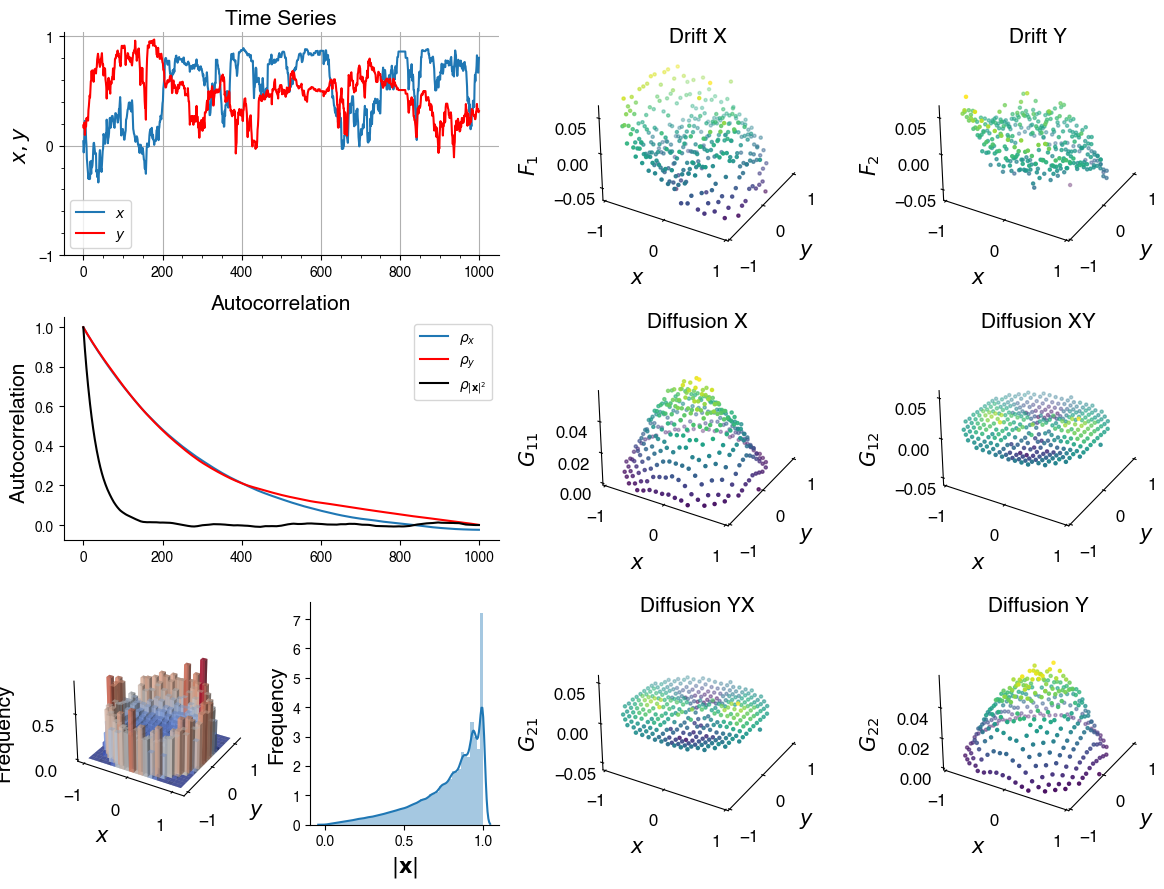

In [3]:
data, t = pydaddy.load_sample_dataset('model-data-vector-ternary')
ddsde = pydaddy.Characterize(data, t, bins=20)

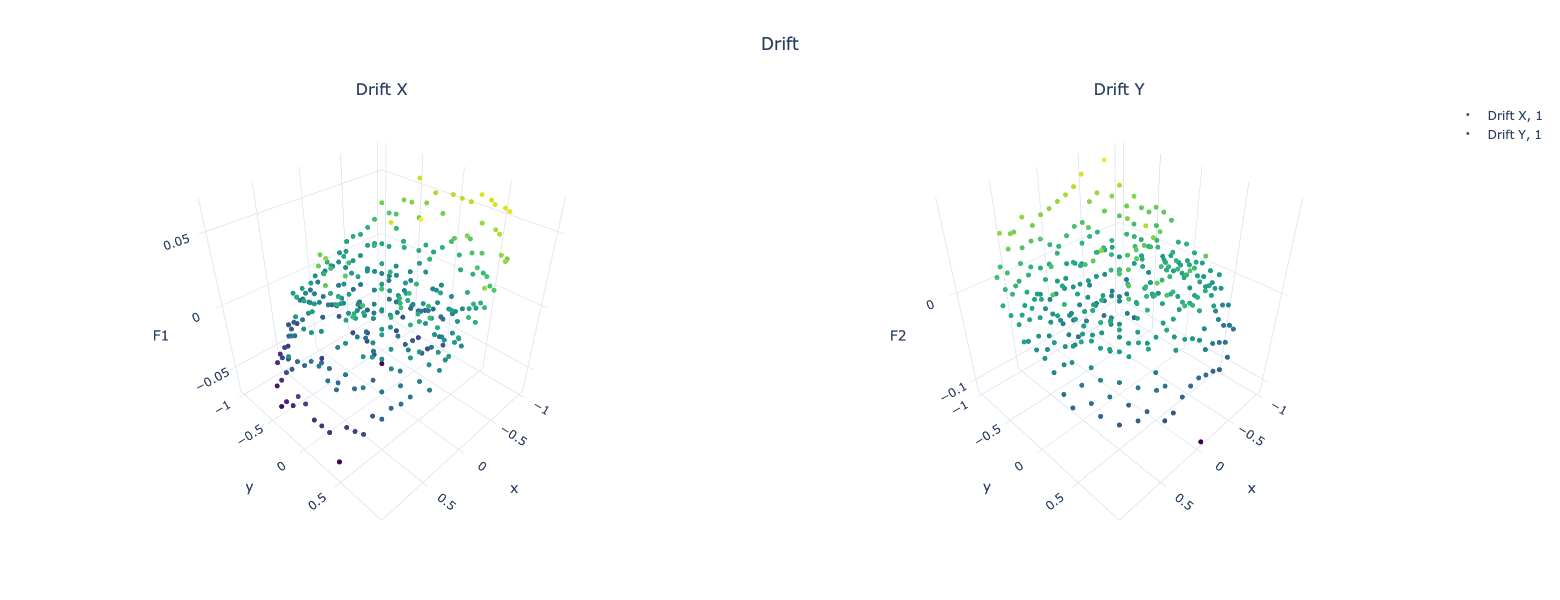

In [4]:
ddsde.drift()

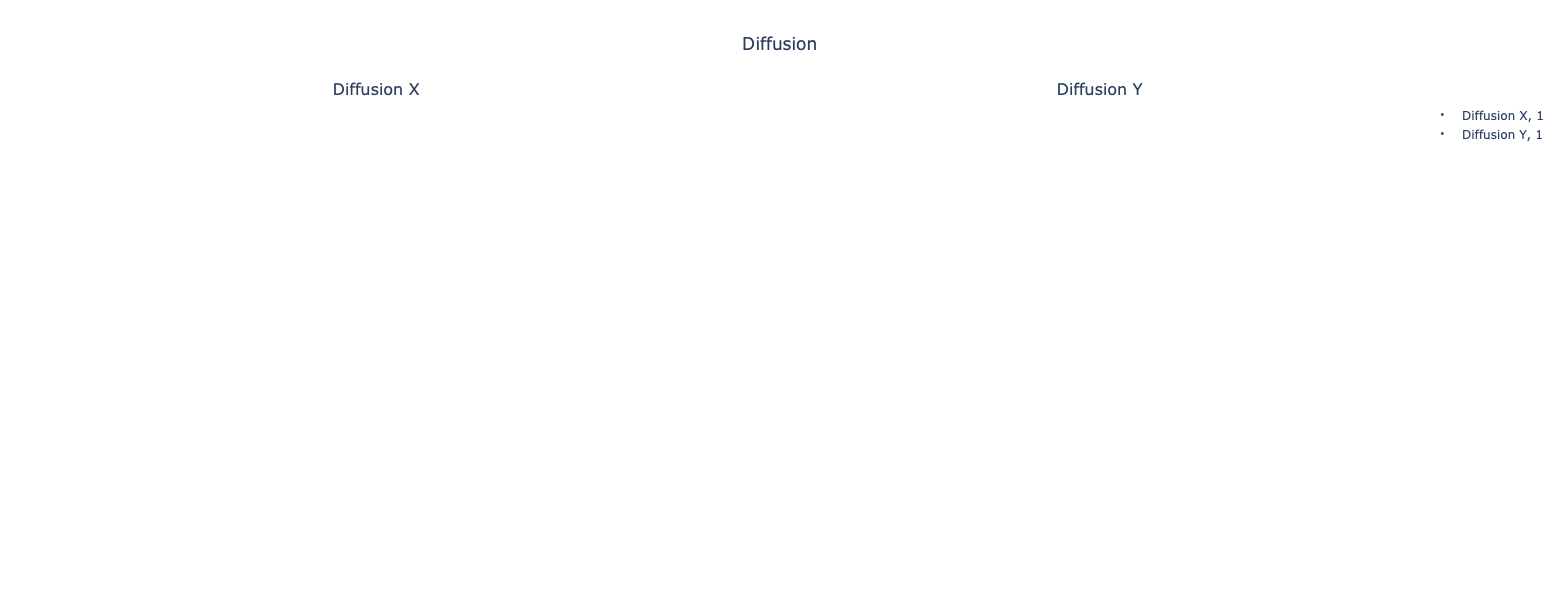

In [5]:
ddsde.diffusion()

From the drift and diffusion plots, it looks like the the diffusion is quadratic. The drift looks cubic.

## Setting the sparsification threshold

The automatic model selection algorithm of `pydaddy` is a good place to start, and usually works well. This can be done by calling `ddsde.fit()` with argument `tune=True`.

The model selection algorithm estimates polynomial fits for a wide range of threshold values; compute the _cross validation error_ for each model, and find the model that achieves the best drop in cross validation error. By default, range of thresholds to search over is automatically determined, but this can be specified manually if required, using the `thresholds` parameter: see the [documentation](http://pydaddy.readthedocs.io/api.html#pydaddy.daddy.Daddy.fit) for more information.

In [ ]:
F1 = ddsde.fit('F1', order=3, tune=True)
print(F1)

In [ ]:
F2 = ddsde.fit('F2', order=3, tune=True)
print(F2)

In [ ]:
G11 = ddsde.fit('G11', order=2, tune=True)
print(G11)

In [ ]:
G22 = ddsde.fit('G22', order=2, tune=True)
print(G22)

## Evaluting and fine-tuning fits

The goodness of the fit can be examined qualitatively by visualizing the fit against the points using `ddsde.drift()` or `ddsde.diffusion()`.

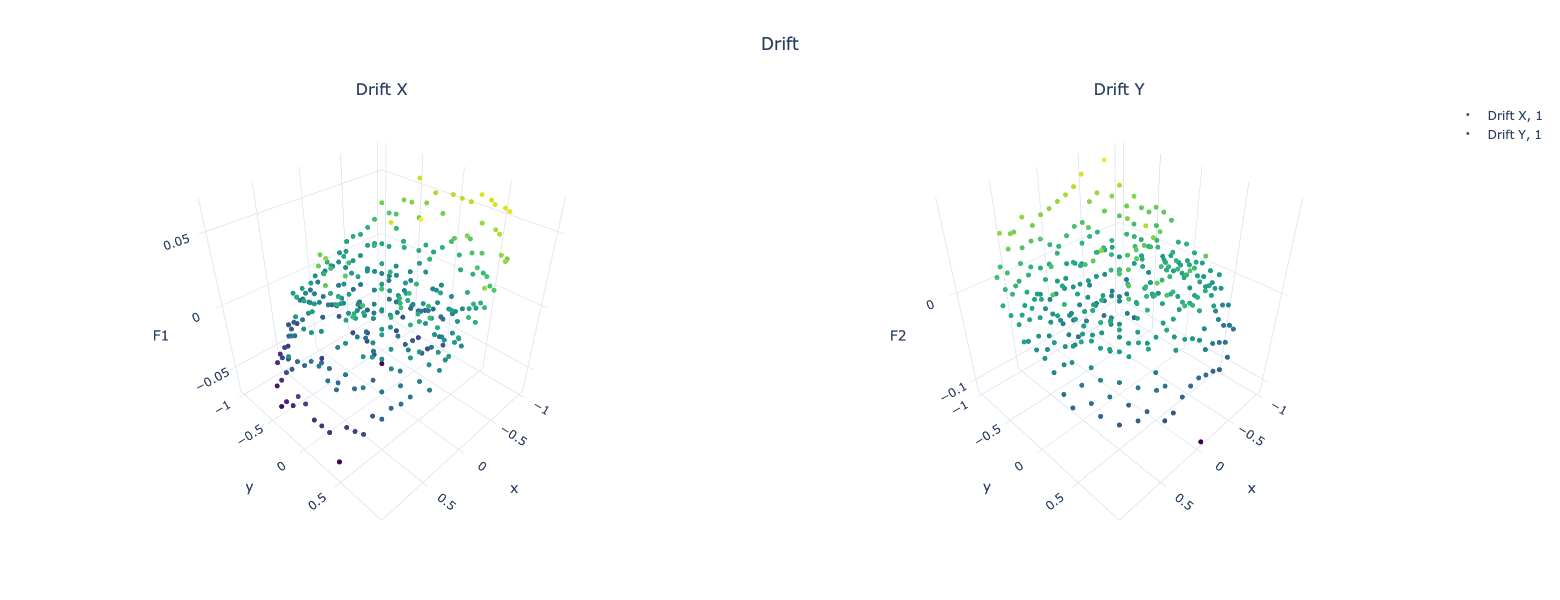

In [6]:
ddsde.drift()

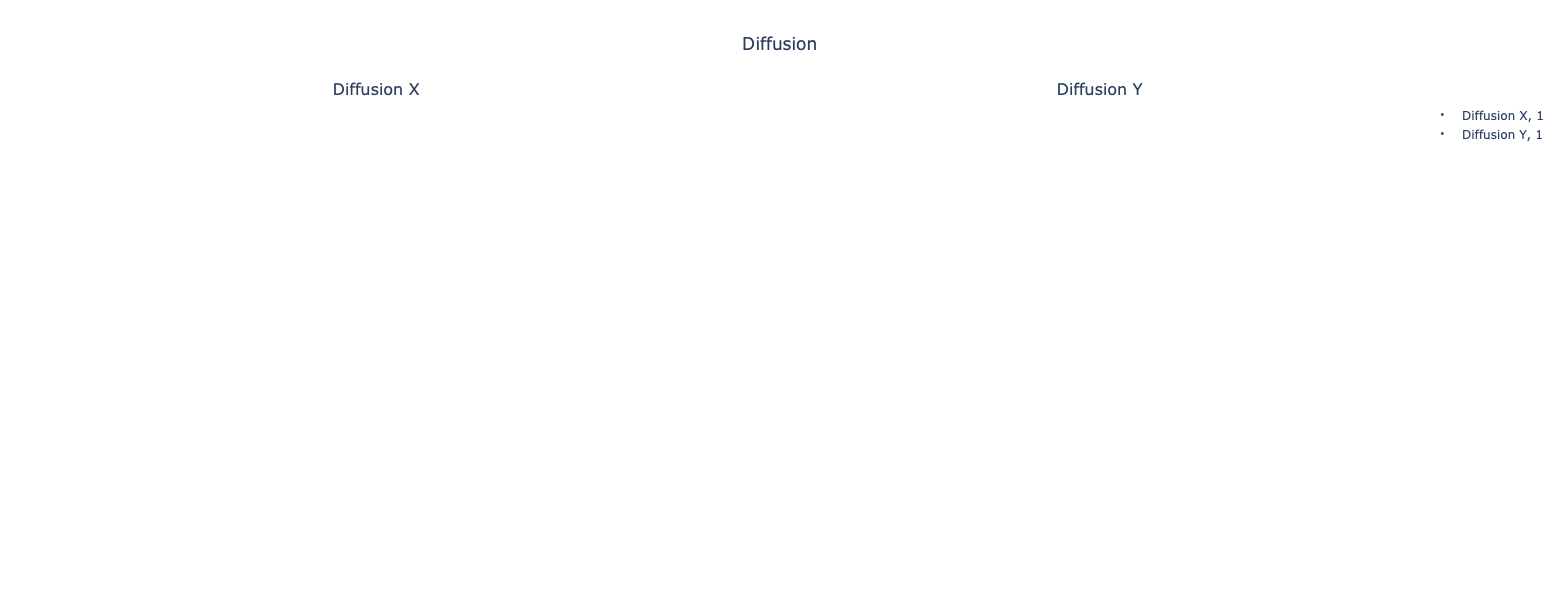

In [7]:
ddsde.diffusion()

For this example, auotmatic model selection (with the correct degree) seems to be doing a good job. However, sometimes, the automatic model selection may fail: it may return a polynomial with many spurious terms. 

The sparse regression algorithm used for fitting uses a sparsity threshold, which can be either manually specified, or be automatically tuned for (as above). The sparsity threshold can be interpreted as follows: for a given value of the sparsity threshold, the fitted polynomial wil only have coefficients with magnitudes higher than the threshold value. Therefore, if you set the threshold too high, there most or all terms will be zeroed out. If the threshold is too low, the result will have too many terms.

When there are spurious terms present, one intuitive approach is to look for terms that are clearly spurious; i.e. some terms with coefficients an order of magnitude lesser than others. We can eliminate these terms by setting a threshold high enough to kill off these terms.

In [8]:
# Threshold too small
print(ddsde.fit('F1', order=3, threshold=0.01))

(0.064 ± 0.003)x + (-0.123 ± 0.005)x^3 + (-0.120 ± 0.005)xy^2 + (0.016 ± 0.004)y^3


In [9]:
# Threshold too high
print(ddsde.fit('F1', order=3, threshold=0.1))

0


In [10]:
# Threshold just right
print(ddsde.fit('F1', order=3, threshold=0.05))

(0.064 ± 0.003)x + (-0.123 ± 0.005)x^3 + (-0.119 ± 0.005)xy^2


A more systematic approach would be to look at the cross-validation curve, to try and identify if there is a clearly suitable threshold value where the CV error is either lowest, or has a significant jump. To this, use call `ddsde.fit()` with `tune=True` and `plot=True`. This will plot the cross validation error and the level of sparsity (i.e. the number of terms) for each level of threshold, helping you choose the right threshold.

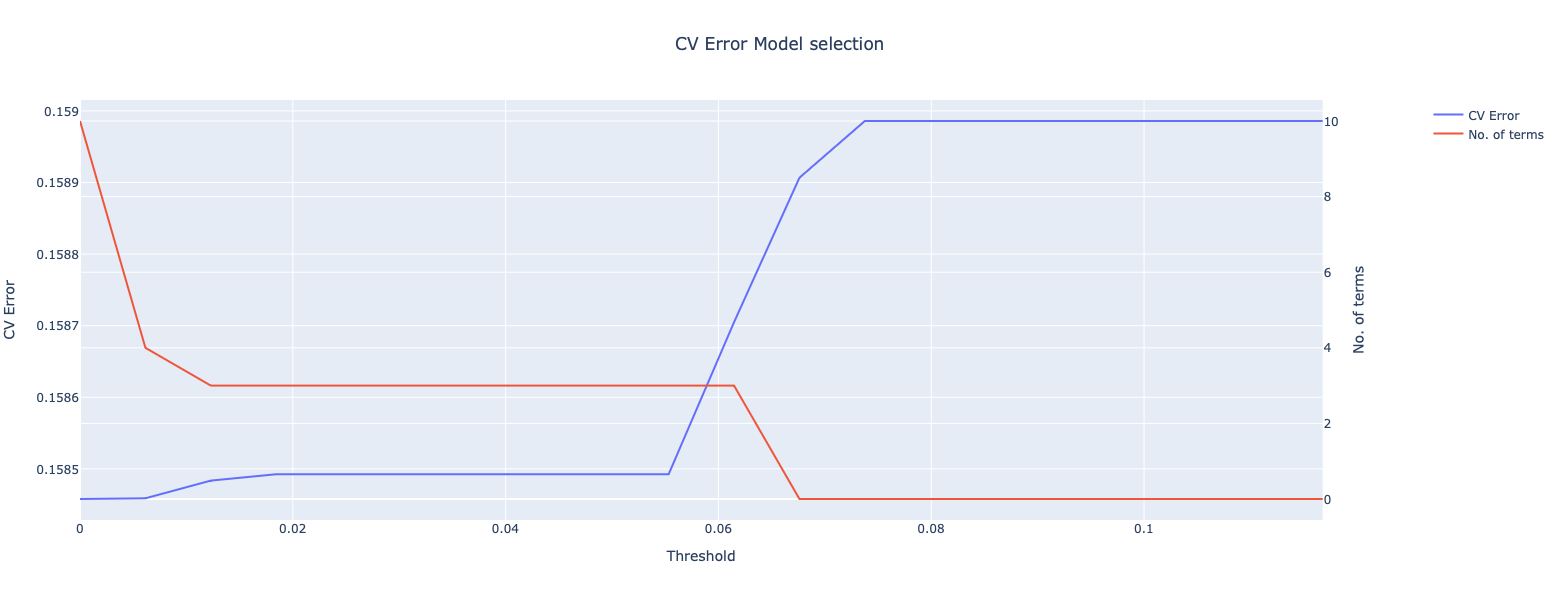

(0.064 ± 0.003)x + (-0.123 ± 0.005)x^3 + (-0.119 ± 0.005)xy^2

In [11]:
ddsde.fit('F1', order=3, tune=True, plot=True)

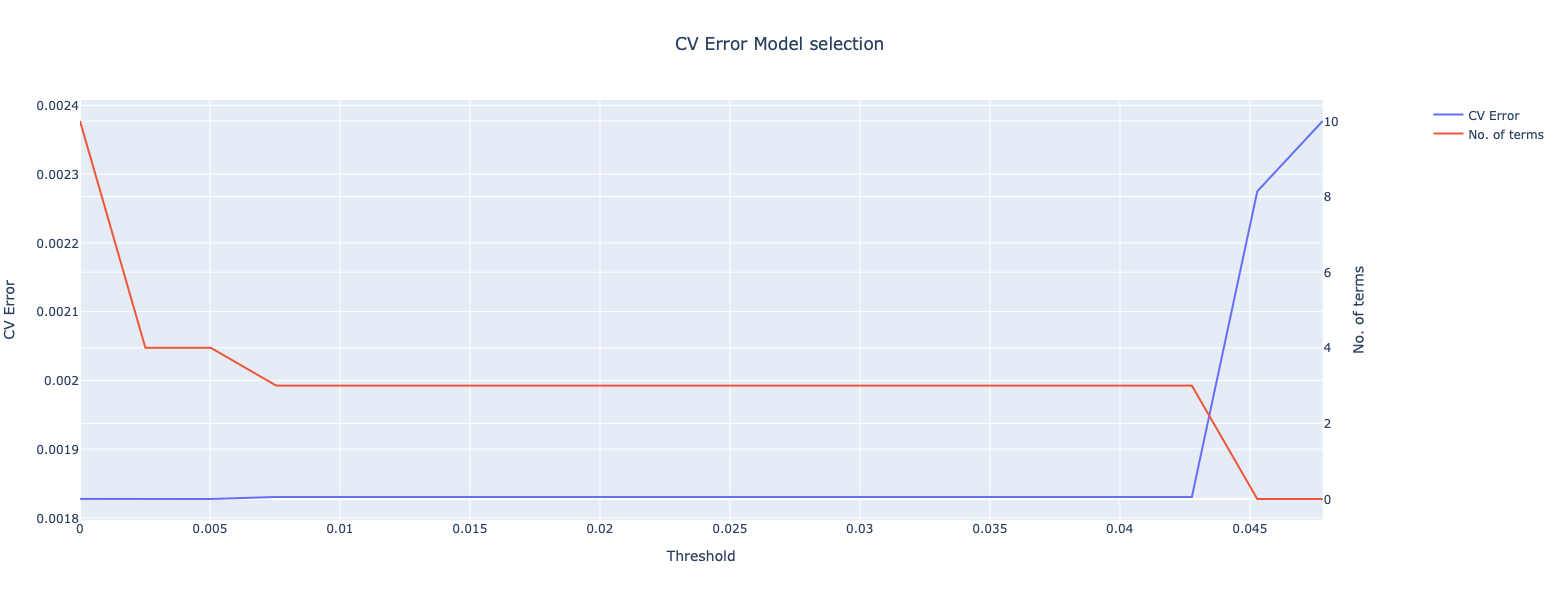

(0.050 ± 0.000) + (-0.045 ± 0.000)x^2 + (-0.050 ± 0.000)y^2

In [12]:
ddsde.fit('G11', order=3, tune=True, plot=True)

In the above example, for $A_1$, thresholds between ~0.02 and ~0.06 seems to give the best trade-off, with 3 terms. Decreasing the threshold further drastically increases the number of terms, with no significant improvement in CV error. Increasing the threshold above 0.6 kills off all the terms and makes the CV error very high.

Similarly, for $B_{11}$, thresholds between ~0.01 and ~0.04 achieve the best trade-off.

In [13]:
print(ddsde.fit('F1', order=3, threshold=0.03))
print(ddsde.fit('G11', order=2, threshold=0.03))

(0.064 ± 0.003)x + (-0.123 ± 0.005)x^3 + (-0.119 ± 0.005)xy^2
(0.050 ± 0.000) + (-0.045 ± 0.000)x^2 + (-0.050 ± 0.000)y^2


## Handling outliers using regularized regression

The `fit()` function has an `alpha` parameter which is a ridge regularization parameter for the polynomial fitting. When a non-zero value of alpha is given, ridge regression is used in the fitting process. This will give best results when the data is noisy or has outliers. 

In cases when a non-zero `alpha` parameter is required, fairly high values of alpha may be required: as a rough rule of thumb, try `alpha=100` to `alpha=1e6` (this is a very vague rule of thumb; your mileage may vary according to your specific dataset). However, be aware of the fact that alpha has the overall effect of shrinking your model parameters: if alpha is too high, your estimated coefficients can be biased to be too small.

As en example, see how fitting the diffusion function with a very large degree gives rise to overfitting, even when the threshold is fairly high.

In [14]:
ddsde.fit('G11', order=10, threshold=0.03)

(0.051 ± 0.000) + (-0.049 ± 0.011)x^2 + (0.105 ± 0.069)x^4 + (-0.283 ± 0.177)x^6 + (0.260 ± 0.195)x^8 + (-0.082 ± 0.077)x^10 + (-0.043 ± 0.012)xy + (0.033 ± 0.102)x^3y + (0.203 ± 0.314)x^5y + (-0.414 ± 0.393)x^7y + (0.219 ± 0.172)x^9y + (-0.082 ± 0.011)y^2 + (0.255 ± 0.119)x^2y^2 + (0.048 ± 0.144)x^3y^2 + (-1.092 ± 0.455)x^4y^2 + (-0.095 ± 0.256)x^5y^2 + (1.487 ± 0.667)x^6y^2 + (0.045 ± 0.144)x^7y^2 + (-0.615 ± 0.329)x^8y^2 + (0.084 ± 0.102)xy^3 + (-0.240 ± 0.510)x^3y^3 + (0.196 ± 0.896)x^5y^3 + (0.054 ± 0.505)x^7y^3 + (0.128 ± 0.069)y^4 + (-0.917 ± 0.450)x^2y^4 + (-0.115 ± 0.315)x^3y^4 + (2.396 ± 0.983)x^4y^4 + (0.119 ± 0.247)x^5y^4 + (-1.596 ± 0.646)x^6y^4 + (-0.136 ± 0.308)xy^5 + (0.506 ± 0.886)x^3y^5 + (-0.416 ± 0.698)x^5y^5 + (-0.253 ± 0.177)y^6 + (1.167 ± 0.655)x^2y^6 + (0.063 ± 0.204)x^3y^6 + (-1.424 ± 0.640)x^4y^6 + (0.178 ± 0.385)xy^7 + (-0.280 ± 0.495)x^3y^7 + (0.256 ± 0.195)y^8 + (-0.506 ± 0.321)x^2y^8 + (-0.084 ± 0.168)xy^9 + (-0.098 ± 0.077)y^10

Setting `alpha` to be fairly high and re-doing the regression eliminates the overfitting.

In [15]:
ddsde.fit('G11', order=10, threshold=0.02, alpha=1000)

(0.048 ± 0.000) + (-0.043 ± 0.011)x^2 + (-0.048 ± 0.011)y^2

Notice that the coefficients from the ridge-regression-based fitting is slightly smaller than the coefficients we obtained during our earlier fits: this is the side effect of ridge regularization. Therefore, non-zero alpha should be only used as a last resort when other attempts fail.

For more information on ridge regression, see:

https://en.wikipedia.org/wiki/Ridge_regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html